In [327]:
## Default imports: don't touch these
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math

In [328]:
%matplotlib inline
from mnist import MNIST
def load_dataset(s="data"):
    mndata = MNIST('../%s/'%s)
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    return (X_train, labels_train), (X_test, labels_test)

In [329]:
(X_train, labels_train), (X_test, labels_test) = load_dataset()

#Perturbing

The MNIST dataset is fairly "clean"; it's been preprocessed and cropped nicely. However, real-world data is not this clean. To make our classifier more robust, we can apply perturb our images ever so slightly so that the classifier learns to deal with various distortions: rotations, skewing, elastic transformations, and noise.

In this test, we examine the effects of training a classifier with **perturbations**, singleton transformations, applied to the training dataset. To simulate a less-than-ideal dataset, we apply a combination of transformations (i.e., "noise") to the test dataset.

## Skewing

To *deskew* an image, we consider each set of pixels along an axis. Consider the values to be a distribution, and convert the distribution to standard normal. To **skew** an image, we do the reverse:

1. Randomly initialize a distribution with an off-center mean and non-zero variance.
2. Distort all pixels by this amount.

## Rotations

To generalize rotations to higher dimensions, we first rotate the centroid for the array. Then, apply the affine transformation $\text{image'} = A(\text{image}) + b$.

## Elastic Transformation



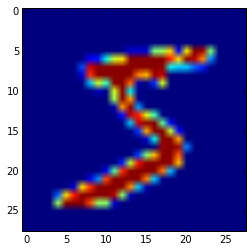

In [330]:
plt.imshow(X_train[0].reshape(28,28)) # This is what the image looks like

In [331]:
examples = [54229,17473, 6642, 29232, 38150, 2186, 58443, 15689, 14413, 14662]

In [332]:
from mpl_toolkits.axes_grid1 import AxesGrid

def draw_examples_with_perturbation(examples, f):
    """Draw examples with provided perturbation f
    
    :param examples: list of examples
    :param f: transformation function with takes a 28x28 image
    and returns a 28x28 image
    """
    examples = [(e, n) for n, e in enumerate(examples)]
    grid = AxesGrid(plt.figure(figsize=(8,15)), 141,  # similar to subplot(141)
                        nrows_ncols=(len(examples), 2),
                        axes_pad=0.05,
                        label_mode="1",
                        )

    for examplenum,num in examples:
        image = X_train[examplenum].reshape(28,28)
        im = grid[2*num].imshow(image)
        im2 = grid[2*num+1].imshow(f(image))

#Perturbations
##Skewing

In [375]:
def skew(image):
    """Skew the image provided.

    Taken from StackOverflow:
    http://stackoverflow.com/a/33088550/4855984
    """
    image = image.reshape(28, 28)
    h, l = image.shape
    distortion = np.random.normal(loc=12, scale=1)

    def mapping(point):
        x, y = point
        dec = (distortion*(x-h))/h
        return x, y+dec+5
    return interpolation.geometric_transform(
        image, mapping, (h, l), order=5, mode='nearest')

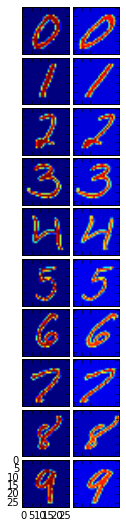

In [376]:
draw_examples_with_perturbation(examples, skew)

##Rotation

In [335]:
def rotate(image, d):
    """Rotate the image by d/180 degrees."""
    center = 0.5*np.array(image.shape)
    rot = np.array([[np.cos(d), np.sin(d)],[-np.sin(d), np.cos(d)]])
    offset = (center-center.dot(rot)).dot(np.linalg.inv(rot))
    return interpolation.affine_transform(
        image,
        rot,
        order=2,
        offset=-offset,
        cval=0.0,
        output=np.float32)

In [336]:
rotate_cw = lambda image: rotate(image, -(3*np.random.random()/5))
rotate_ccw = lambda image: rotate(image, 3*np.random.random()/5)

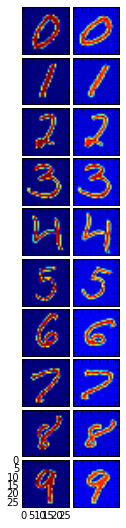

In [337]:
draw_examples_with_perturbation(examples, rotate_cw)

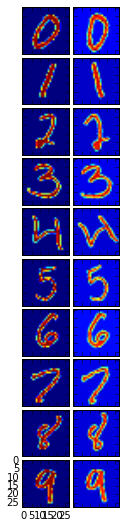

In [338]:
draw_examples_with_perturbation(examples, rotate_ccw)

##Noise

In [339]:
def noise(image, n=100):
    """Add noise by randomly changing n pixels"""
    indices = np.random.random(size=(n, 2))*28
    image = image.copy()
    for x, y in indices:
        x, y = int(x), int(y)
        image[x][y] = 0
    return image

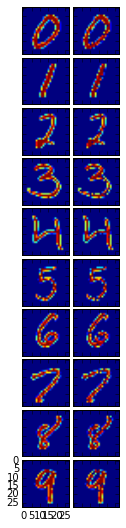

In [340]:
draw_examples_with_perturbation(examples, noise)

## Elastic Transformations

In [387]:
def elastic_transform(image, alpha=36, sigma=5, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    
    :param image: a 28x28 image
    :param alpha: scale for filter
    :param sigma: the standard deviation for the gaussian
    :return: distorted 28x28 image
    """
    assert len(image.shape) == 2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

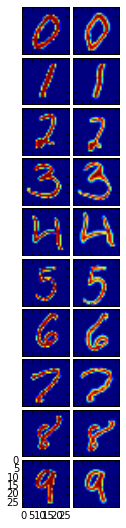

In [388]:
draw_examples_with_perturbation(examples, elastic_transform)

##Results

In [379]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
import sklearn.metrics as metrics

In [380]:
def createModel(x,y):
    yp = OneHotEncoder()
    y = yp.fit_transform(y.reshape(x.shape[0],1)).toarray()
    clf = linear_model.Ridge (alpha = 0)
    clf.fit(x,y)
    return clf

def predict(model,x):
    return np.argmax(model.predict(x),axis=1)

In [435]:
def vectorize(f):
    def vectorized(X):
        X = X.copy()
        for i, row in enumerate(X):
            X[i] = f(row.reshape(28, 28)).reshape(784)
        return X
    return vectorized

# perturbations
perturb_rotate_cw = vectorize(rotate_cw)
perturb_rotate_ccw = vectorize(rotate_ccw)
perturb_skew = vectorize(skew)
perturb_noise = vectorize(noise)
perturb_elastic_transform = vectorize(elastic_transform)
perturb_rotate_elastic_transform = vectorize(lambda image: rotate(elastic_transform(image), 15*np.pi/180))

# combinations of perturbations, to simulate a noisy dataset
perturb_noise_rotate = vectorize(lambda image: noise(rotate_cw(image)))
perturb_noise_skew = vectorize(lambda image: noise(skew(image)))
perturb_noise_elastic_transform = vectorize(lambda image: noise(elastic_transform(image)))

In [437]:
from math import ceil

def perturb(X, labels):
    """Perturb the data in place, by applying various combinations of noise."""
    size = ceil(X.shape[0]/4)
    X_test_perturbed = perturb_skew(X[:size])
    X_test_perturbed = np.concatenate([X_test_perturbed, perturb_noise_rotate(X[size:2*size])])
    X_test_perturbed = np.concatenate([X_test_perturbed, perturb_noise_skew(X[2*size:3*size])])
    X_test_perturbed = np.concatenate([X_test_perturbed, perturb_noise_elastic_transform(X[3*size:4*size])])
    
    indices = list(range(X.shape[0]))
    np.random.shuffle(indices)
    return X_test_perturbed[indices], labels[indices]

In [381]:
model_unchanged = createModel(X_train, labels_train)

In [448]:
X_test_noisy, labels_test_noisy = perturb(X_test, labels_test)

In [454]:
metrics.accuracy_score(predict(model_unchanged, X_train), labels_train)

0.85016666666666663

In [455]:
metrics.accuracy_score(predict(model_unchanged, X_test_noisy), labels_test_noisy)

0.23619999999999999

In [428]:
def perturb_extend(X, labels, dim=28, n=2500):
    """Duplicate training data, by perturbing each image several ways.
    Taken from gist at https://gist.github.com/fmder/e28813c1e8721830ff9c.

    Each image will see the following perturbations:
    1. rotation clockwise
    2. rotation counterclockwise
    3. skew
    4. noise
    5. elastic transformation
    """
    num_transformations = 6

    print('[Perturb] Preprocessing images...')
    indices = np.random.random_integers(low=0, high=X.shape[0]-1, size=n)
    X_featurize = X[indices]
    labels_featurize = labels[indices]
    X_new = np.concatenate([X, perturb_skew(X_featurize)])
    X_new = np.concatenate([X_new, perturb_rotate_cw(X_featurize)])
    X_new = np.concatenate([X_new, perturb_rotate_ccw(X_featurize)])
    X_new = np.concatenate([X_new, perturb_noise(X_featurize)])
    X_new = np.concatenate([X_new, perturb_elastic_transform(X_featurize)])
    X_new = np.concatenate([X_new, perturb_rotate_elastic_transform(X_featurize)])

    print('[Perturb] All samples generated. Shuffling...')

    labels_new = np.concatenate([labels] + [labels_featurize]*num_transformations)

    print('[Perturb] Preprocessing complete. ({num}x{n} samples)'.format(
        num=num_transformations,
        n=n
    ))
    return X_new.reshape(X_new.shape[0], dim*dim), labels_new
    
X_train_perturbed, labels_train_perturbed = perturb_extend(X_train, labels_train)

[Perturb] Preprocessing images...
[Perturb] All samples generated. Shuffling...
[Perturb] Preprocessing complete. (6x2500 samples)
[Perturb] Preprocessing images...
[Perturb] All samples generated. Shuffling...
[Perturb] Preprocessing complete. (6x2500 samples)


In [456]:
model_perturbed = createModel(X_train_perturbed, labels_train_perturbed)

In [457]:
metrics.accuracy_score(predict(model_perturbed, X_train_perturbed), labels_train_perturbed)

0.82152000000000003

In [458]:
metrics.accuracy_score(predict(model_perturbed, X_test_noisy), labels_test_noisy)

0.67449999999999999

# Overall Results

Using L2 Regularized Regression (Ridge Regression), we have


### Baseline

Train Accuracy: 85.01%  
Test Accuracy: 23.62%

### Train with Perturbations

Train Accuracy: 82.15%  
Test Accuracy: 67.44%

##Conclusion

We see that training with perturbations doubled our test accuracy, when testing against noisier datasets. In iother words, the second classifier is far more generalized than the first.

This demonstration is flawed, as we train for the very transformations that we test against. However, this demonstrates that even training on singleton transformations is enough to make a classifier more robust, against combinations of transformations. Thus, we can apply this more broadly by identifying only a few transformations.